In [1]:
################################################
#Building segmentation prediction for each camp#
#Maintainer: Christopher Chan                  #
#Date: 2022-07-12                              #
#Version: 0.1.1                                #
################################################

import os, sys, re
import torch
import PIL
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import segmentation_models_pytorch as smp
from scipy import ndimage
from PIL import Image
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from Networks import Five_UNet, Four_UNet
from dataloader import PredictionDataset
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))

print(f"Training on device {device}.")

data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/ALL_IMG_15cm")

Training on device cpu.


In [5]:
# Function to load trained weights to appropriate architecture to predict a certain camp

def loading(trained_weights, architecture, camp):
    IMG_ls = []
    Network = []

    if camp == "KBY":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if f.startswith("KBY15_IMG"):
                        IMG_ls.append(root + "/" + f)
                        
    elif camp == "DZK":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if f.startswith("DZK15_IMG"):
                        IMG_ls.append(root + "/" + f)
    
    elif camp == "DZKN":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if f.startswith("DZKN15_IMG"):
                        IMG_ls.append(root + "/" + f)
    
##############################################################

    # Load non-weighted architecture
    if architecture == "EB0-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b0', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
    
    elif architecture == "EB1-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None) 
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
    
        
       
    elif architecture == "qubvel":
        Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
        qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
        qubvel_weights = torch.load(qubvel_weights, map_location = device)
        Net.load_state_dict(qubvel_weights["state_dict"])
    
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)

    elif architecture == "EB2-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b2', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels= 3 , classes = 1, activation = "sigmoid", aux_params = None)
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
         
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
   
    elif architecture == "Four_Unet":
        Net = Four_UNet()
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
        
    elif architecture == "Five_Unet":
        Net = Five_UNet()
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
        
    print("Selected CNN architecture: {0} to predict camp {1}, which contains {2} images.".format(architecture, camp, len(IMG_ls)))
    
    # Load dataset and predict:
    loader = DataLoader(PredictionDataset(IMG_ls), batch_size = 1, shuffle = True)
    for i, img in tqdm(enumerate(loader), total = len(loader)):
        img = img.to(device = device)
        with torch.no_grad():
            prediction = Net(img)
            prediction = prediction.squeeze(0)
    
            pred_BOOL = (prediction > 0.001).to(torch.float32)
    
            # Booleanise
            pred_BOOL = pred_BOOL.bool()
          
    return img, prediction, pred_BOOL

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 586/586 [14:11<00:00,  1.45s/it]


Text(0.5, 1.0, 'Binary Segmentation')

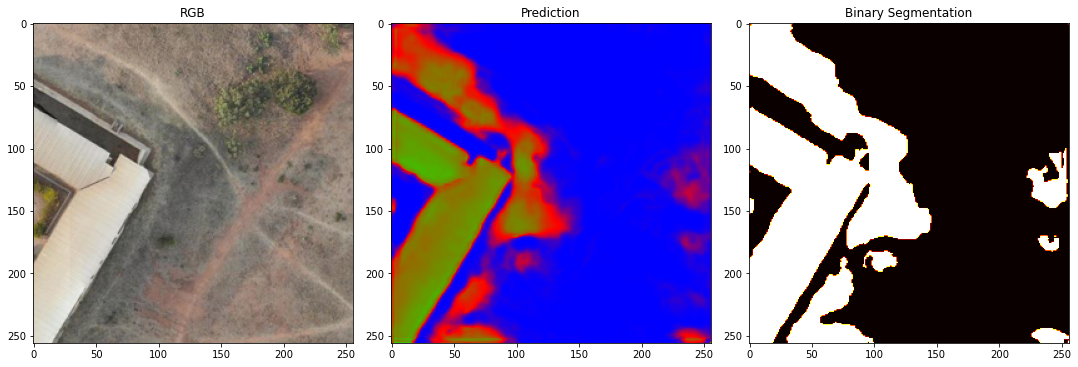

In [9]:
best_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/best_weights/BASE_15cmALL")

img, prediction, pred_BOOL = loading(os.path.join(best_weights, "18242:3909_256oc_EB1-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_223260.pth"),
                                     "EB1-Unet", "DZKN")

 
# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 3, 1)
fig.tight_layout(w_pad = 3)
#fig.suptitle("256x256(15cm) {0} | {1}".format(camp, trained_weights))
RGB = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(RGB)
ax.set_title('RGB')

ax = fig.add_subplot(1, 3, 2)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 3, 3)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')